# How to adjust the advertising budget ?

We work as analysts for the telecommunications operator Megaline. The company offers its customers two subscription rates: Surf and Ultimate. The commercial department wants to know which of the plans generates more income for adjust the advertising budget.

# Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#data_review)
    * [1.1 Explore initial data - Calls](#calls)
    * [1.2 Explore initial data - Internet](#internet)
    * [1.3 Explore initial data - Messages](#messages)
    * [1.4 Explore initial data - Users](#users)
    * [1.5 Explore initial data - Plans](#plans)
* [Stage 2. Data preparation](#data_preparation)
    * [2.1 Data grouping](#data_grouping)
    * [2.2 Dataframes joining](#data_joining)
    * [2.3 Extra cost calculation](#extra_cost)
* [Stage 3. Data analysis](#data_analysis)
    * [3.1 Call analysis](#call_analysis)
    * [3.2 SMS analysis](#sms_analysis)
    * [3.3 Internet analysis](#Internet_analysis)
    * [3.4 Month-by-month income analysis](#income_analysis)
* [Stage 4. Hypotesis testing](#hypotesis_testing)
    * [4.1 Test: inequality of the averages 'Surf' and 'Ultimate'](#first_test)
    * [4.2 Test: inequality of the averages 'New York' and 'not New York'](#second_test)
    * [4.3 Last details](#details)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

In this exercise we are going to perform a preliminary analysis of tariffs based on a selection of customers. Who are the customers, where are they from, what rate they use, the number of calls they did, the text messages they sent and the data they used in 2018. Our job is to analyze customers behavior and determine which prepaid rate generates more income.

## Stage 1. Data loading and preprocessing <a id='data_review'></a>

In [1]:
# Loading all libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math

In [2]:
# Load the data files into DataFrame
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

Let's see, one by one, all the loaded datasets to be aware on what kind of info we have

### 1.1 Explore initial data - Calls <a id='calls'></a>

In [3]:
# printing the general/summary information about the DataFrame
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


The dataset contains the following fields:
- `id` — unique identifier of the call
- `user_id` — the identifier of the calling user
- `call_date` — date of the call
- `duration` — duration of the call (in minutes)

In [4]:
# printing a data sample
df_calls.head(20)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


Megaline rounds seconds to minutes. For 'duration' column, each individual call is rounded up: even if the call lasted only one second will be counted as one minute. The calls whose duration is 0sec mean they are unanswered calls.

In [5]:
# counting the unanswered calls
len(df_calls.loc[df_calls['duration'] == 0])

26834

Let's now see what percentage of unanswered calls there are out of the total dataframe

In [6]:
perce = len(df_calls.loc[df_calls['duration'] == 0, 'duration'])/len(df_calls)
print(f'Percentage of unanswered calls: {perce:.0%}')

Percentage of unanswered calls: 19%


So, 26834 out of 137735 calls had no answer. Since this is a great percentage and since those calls represent after all a user activity, we keep them

Lets round up the duration of the calls

In [7]:
# Rounding up the duration
df_calls['duration'] = np.ceil(df_calls['duration'])

Let's now convert type of "call_date" column to datetime and from float to int the "duration" column

In [8]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['duration'] = df_calls['duration'].astype(int)

Let's see what are the soonest and latest call samples

In [9]:
print(min(df_calls['call_date']))
print(max(df_calls['call_date']))

2018-01-15 00:00:00
2018-12-31 00:00:00


So the first and last call were made respectively the 15th January 2018 and 31st December 2018 

In [10]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 3.7+ MB


Ok, everything is fine. We can proceed with the next dataframe

### 1.2 Explore initial data - Internet <a id='internet'></a>

In [11]:
# printing the general/summary information about the DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


The dataset contains the following fields:
- `id` — unique identifier of the call
- `user_id` — user identifier
- `session_date` — web session date
- `mb_used` — the amount of data spent during the session (in megabytes)

In [12]:
# printing a data sample
df_internet.head(20)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


Megaline rounds megabytes to gigabytes (GB). Individual web sessions are not rounded. The total for the month is rounded up. For instance, if someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Lets count the connections with no data exchanged

In [13]:
#counting the connections with no data exchanged
len(df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'])

13747

Let's now see what percentage of connections with no data exchanged there are out of the total dataframe

In [14]:
# percentage of connections with no data exchanged
perce = len(df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'])/len(df_internet)
print(f'Percentage of unanswered calls: {perce:.0%}')

Percentage of unanswered calls: 13%


So, 13747 out of 104825 connections had no data exchanged. This does not actually represent a big deal. So we can carry on 

Let's now convert type of "session_date" column to datetime 

In [15]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

Let's see what are the soonest and latest session date

In [16]:
print(min(df_internet['session_date']))
print(max(df_internet['session_date']))

2018-01-15 00:00:00
2018-12-31 00:00:00


As for "call_date" the first and last action are respectively January 15 and December 31, 2018

### 1.3 Explore initial data - Messages <a id='messages'></a>

In [17]:
# printing the general/summary information about the DataFrame
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


The dataset contains the following fields:
- `id` — unique identifier of the call
- `user_id` — user identifier
- `message_date` — SMS date

In [18]:
# printing a data sample
df_messages.head(20)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


Let's now convert type of "message_date" column to datetime 

In [19]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

Let's see what are the soonest and latest message date

In [20]:
print(min(df_messages['message_date']))
print(max(df_messages['message_date']))

2018-01-15 00:00:00
2018-12-31 00:00:00


As for "call_date" the first and last action are respectively January 15 and December 31

### 1.4 Explore initial data - Users <a id='users'></a>

In [21]:
# printing the general/summary information about the DataFrame
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


The dataset contains the following fields:
- `user_id` — the identifier of the calling user
- `first_name` 
- `last_name` 
- `age` 
- `city` — user's city of residence
- `reg_date` — subscription date (dd, mm, yy)
- `plan`  — user's plan (Surf or Ultimate)
- `churn_date` — the date the user stopped using the service (if the value is
                 absent, the prepaid rate was in use when this data was generated)

In [22]:
# printing a data sample
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


So, there are 500 users (from user_id 1000 to 1499). Every column is fully filled except the "churn_date". When this value is absent means that the offer was being used during the data extraction 

Let's now convert type of "reg_date" and "churn_date" column to datetime

In [23]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

In [24]:
print(min(df_users['reg_date']))
print(max(df_users['reg_date']))

2018-01-01 00:00:00
2018-12-31 00:00:00


This last means that the first registered customer was in 1st January and the last in 31st December

### 1.5 Explore initial data - Plans <a id='plans'></a>

In [25]:
# printing the general/summary information about the DataFrame
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


The dataset contains the following fields:
- `messages_included` — SMS included per month
- `mb_per_month_included` — data included per month (in megabytes)
- `minutes_included` — included minutes per month
- `usd_monthly_pay` — monthly fee in US dollars
- `usd_per_gb` — price per gigabyte of extra data after exceeding the limits of the package (1 GB = 1024 megabytes)
- `usd_per_message` — price per SMS after exceeding package limits
- `usd_per_minute` — price per minute after exceeding package limits (for example, if the package includes 100 minutes, the operator will charge the minute 101)
- `plan_name`

In [26]:
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


This last dataframe is pretty simple. It is a description of both plans

## Stage 2. Data preparation <a id='data_preparation'></a>

To achieve our goal, we need a new dataframe with following columns:
- `user_id`
- `month`  
- `duration` — used minutes per month
- `gb_used` — data used per month (in megabytes)
- `sms` — SMS sent per month
- `plan` — offer chosen
- `city` 
- `basic_fee` — monthly fee in US dollars
- `extra_fee` — extra fee to pay when using the offer beyond limit
- `total_fee` — sum of the two fees

Since we have to extract some columns from our dataframes, first we have to group them according to user id and month. But before doing that, since we do not have a column that reports the month on df_calls, df_messages and df_internet, we have to add it to these dataframes 

In [27]:
# adding 'month' column on df_calls
df_calls['month'] = df_calls['call_date'].dt.month

In [28]:
# adding 'month' column on df_messages
df_messages['month'] = df_messages['message_date'].dt.month

In [29]:
# adding 'month' column on df_internet
df_internet['month'] = df_internet['session_date'].dt.month

Lets now group our updated dataframes by 'user_id' and 'month' and select one by one the:
- call duration
- call counter
- sent sms
- data used

### 2.1 Data grouping <a id='data_grouping'></a>

In [30]:
data_calls = df_calls.groupby(['user_id', 'month'])[['duration']].sum()
data_calls

duration
user_id month          
1000    12          124
1001    8           182
        9           315
        10          393
        11          426
...                 ...
1498    12          339
1499    9           346
        10          385
        11          308
        12          496

[2258 rows x 1 columns]

In [31]:
data_calls_count = df_calls.groupby(['user_id', 'month'])[['id']].count()
# renaming the column from 'id' to 'call_counter'
data_calls_count.rename(columns = {'id':'call_count'}, inplace = True)
data_calls_count

call_count
user_id month            
1000    12             16
1001    8              27
        9              49
        10             65
        11             64
...                   ...
1498    12             39
1499    9              41
        10             53
        11             45
        12             65

[2258 rows x 1 columns]

In [32]:
data_messages = df_messages.groupby(['user_id', 'month'])[['id']].count()
# renaming the column from 'id' to 'sms'
data_messages.rename(columns = {'id':'sms'}, inplace = True)
data_messages

sms
user_id month     
1000    12      11
1001    8       30
        9       44
        10      53
        11      36
...            ...
1496    9       21
        10      18
        11      13
        12      11
1497    12      50

[1806 rows x 1 columns]

In [33]:
data_internet = df_internet.groupby(['user_id', 'month'])[['mb_used']].sum()
data_internet

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

Cool, we have now our partial and "ad-hoc" dataframes. One last thing we have to do before merging these dataframes is changing the 'mb_used' column to 'gb_used' and round the value to the upper closest int value

In [34]:
data_internet['mb_used'] = (data_internet['mb_used']/1024).apply(np.ceil)
data_internet.rename(columns = {'mb_used':'gb_used'}, inplace = True)
data_internet['gb_used'] = data_internet['gb_used'].astype(int)

### 2.2 Dataframes joining <a id='data_joining'></a>

Lets now join these dataframes together. Since data_internet is the biggest dataframe, we begin the joining process with it

In [35]:
new_df = data_internet.join(data_messages, on=['user_id', 'month'], how='outer')
new_df = new_df.join(data_calls, on=['user_id', 'month'], how='outer')
new_df = new_df.join(data_calls_count, on=['user_id', 'month'], how='outer')
new_df

gb_used    sms  duration  call_count
user_id month                                      
1000    12         2.0   11.0     124.0        16.0
1001    8          7.0   30.0     182.0        27.0
        9         14.0   44.0     315.0        49.0
        10        22.0   53.0     393.0        65.0
        11        19.0   36.0     426.0        64.0
...                ...    ...       ...         ...
1470    12         NaN  153.0     592.0        78.0
1482    10         NaN    2.0       NaN         NaN
1484    11         NaN    1.0      38.0         2.0
1491    4          NaN    6.0      44.0         8.0
1044    8          NaN    NaN      13.0         1.0

[2293 rows x 4 columns]

In [36]:
# printing the general/summary information about the DataFrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1044, 8)
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gb_used     2277 non-null   float64
 1   sms         1806 non-null   float64
 2   duration    2258 non-null   float64
 3   call_count  2258 non-null   float64
dtypes: float64(4)
memory usage: 98.9 KB


We got a 2277 rows dataframes with 3 columns that have null values. We can just replace them all with zero

In [37]:
# replacing all null values with zeros
new_df = new_df.fillna(0)

We are going to need also the info as subscription plan and city of each user. So, lets get a "ad-hoc" table that has that

In [38]:
df_users_2 = df_users[['user_id', 'plan', 'city']]
df_users_2

,user_id,plan,city
0,1000,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1002,surf,"Las Vegas-Henderson-Paradise, NV MSA"
3,1003,surf,"Tulsa, OK MSA"
4,1004,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...
495,1495,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,1496,surf,"New Orleans-Metairie, LA MSA"
497,1497,ultimate,"Los Angeles-Long Beach-Anaheim, CA MSA"
498,1498,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"


To simplify the merge, we need to reset the index of the dataframe new_df

In [39]:
new_df = new_df.reset_index()

Lets merge this last table to new_df

In [40]:
# merging new_df with df_users_2
new_df = new_df.merge(df_users_2, on=['user_id'])
new_df

,user_id,month,gb_used,sms,duration,call_count,plan,city
0,1000,12,2.0,11.0,124.0,16.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,7.0,30.0,182.0,27.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,14.0,44.0,315.0,49.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,22.0,53.0,393.0,65.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,19.0,36.0,426.0,64.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2288,1470,8,0.0,141.0,580.0,84.0,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
2289,1470,9,0.0,130.0,471.0,70.0,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
2290,1470,10,0.0,145.0,459.0,72.0,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
2291,1470,11,0.0,156.0,632.0,81.0,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"


In this last operation, we lost the month column but it's not a big deal. So, we can proceed calculating the income user by user

Next step we'll do is adding a new column that report the monthly basic fee for each user

In [41]:
new_df['basic_pay'] = new_df['plan'].replace({'surf' : 20, 'ultimate': 70})

Now, we need to calculate the extra costs related to an over-consumption of minutes, sms or data

First thing we do, is set new void columns:
- 'extra_call_price'
- 'extra_sms_price'
- 'extra_data_price'

In [42]:
new_df['extra_call_price'] = ''
new_df['extra_sms_price'] = ''
new_df['extra_data_price'] = ''

Lets now get the extra cost one by one with the following algorithms

In [43]:
for i in new_df.index:
    if new_df['plan'][i] == 'ultimate':
        if new_df['duration'][i] <= 3000:
            new_df['extra_call_price'][i] = 0
        else:
            extra_call = new_df['duration'][i] - 3000
            new_df['extra_call_price'][i] = extra_call * 0.01
    if new_df['plan'][i] == 'surf':
        if new_df['duration'][i] <= 500:
            new_df['extra_call_price'][i] = 0
        else:
            extra_call = new_df['duration'][i] - 500
            new_df['extra_call_price'][i] = extra_call * 0.03

C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\4192743431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_call_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\4192743431.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_call_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\4192743431.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_call_price'][i] 

In [44]:
for i in new_df.index:
    if new_df['plan'][i] == 'ultimate':
        if new_df['sms'][i] <= 1000:
            new_df['extra_sms_price'][i] = 0
        else:
            extra_sms = new_df['sms'][i] - 1000
            new_df['extra_sms_price'][i] = extra_sms * 0.01
    if new_df['plan'][i] == 'surf':
        if new_df['sms'][i] <= 50:
            new_df['extra_sms_price'][i] = 0
        else:
            extra_sms = new_df['sms'][i] - 50
            new_df['extra_sms_price'][i] = extra_sms * 0.03

C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\1688731404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_sms_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\1688731404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_sms_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\1688731404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_sms_price'][i] = e

In [45]:
for i in new_df.index:
    if new_df['plan'][i] == 'ultimate':
        if new_df['gb_used'][i] <= 13:
            new_df['extra_data_price'][i] = 0
        else:
            extra_data = new_df['gb_used'][i] - 13
            new_df['extra_data_price'][i] = extra_data * 7
    if new_df['plan'][i] == 'surf':
        if new_df['gb_used'][i] <= 15:
            new_df['extra_data_price'][i] = 0
        else:
            extra_data = new_df['gb_used'][i] - 15
            new_df['extra_data_price'][i] = extra_data * 10

C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\2810448867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_data_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\2810448867.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_data_price'][i] = 0
C:\Users\vidam\AppData\Local\Temp\ipykernel_10256\2810448867.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['extra_data_price'][i] 

Lets add a column with the total income from the single user

In [46]:
new_df['total_pay'] = new_df['basic_pay'] + new_df['extra_call_price'] + new_df['extra_sms_price'] + new_df['extra_data_price']

## Stage 3. Data analysis <a id='data_analysis'></a>

Now we can get the overall basic income that Megaline made in the year 2018 from 'surf' and 'ultimte' customers

In [47]:
# Income from basic_pay of surf customer
basic_surf = 0
for i in new_df.index:
    if new_df['plan'][i] == 'surf':
        basic_surf +=20

print(f'The income from basic_pay of surf customers is: {basic_surf} $')



# Income from basic_pay of ultimate customer
basic_ultimate = 0
for i in new_df.index:
    if new_df['plan'][i] == 'ultimate':
        basic_ultimate +=70

print(f'The income from basic_pay of ultimate customers is: {basic_ultimate} $')

The income from basic_pay of surf customers is: 31460 $
The income from basic_pay of ultimate customers is: 50400 $


And the overall total income that Megaline made in the year 2018 from 'surf' and 'ultimte' customers

In [48]:
# Total income from surf customer
tot_surf = 0
for i in new_df.index:
    if new_df['plan'][i] == 'surf':
        tot_surf += new_df['total_pay'][i]

tot_surf = tot_surf.astype(int)        
print(f'The total income from surf customers is: {tot_surf} $')


# Total income from ultimate customer
tot_ultimate = 0
for i in new_df.index:
    if new_df['plan'][i] == 'ultimate':
        tot_ultimate += new_df['total_pay'][i]

tot_ultimate = tot_ultimate.astype(int)
print(f'The total income from ultimate customers is: {tot_ultimate} $')

The total income from surf customers is: 95491 $
The total income from ultimate customers is: 78197 $


### 3.1 Call analysis <a id='call_analysis'></a>

Now we are going to describe the behavior of customers. Finding the minutes, SMS and data required per month by the users of both offers and getting the mean and standard deviation

In [49]:
print("The average call duration of 'surf' customers is:", np.mean(new_df.loc[new_df['plan'] == 'surf', ['duration']], axis=0).mean().round())
print("The average call duration of 'ultimate' customers is:", np.mean(new_df.loc[new_df['plan'] == 'ultimate', ['duration']], axis=0).mean().round())

The average call duration of 'surf' customers is: 429.0
The average call duration of 'ultimate' customers is: 430.0


Lets now get the standard deviation for call duration of both customers

In [50]:
# Calculating the σ for call duration of 'surf' users
np.std(new_df.loc[new_df['plan'] == 'surf', ['duration']], axis=0)

duration    234.378614
dtype: float64

In [51]:
# Calculating the σ for call duration of 'ultimate' users
np.std(new_df.loc[new_df['plan'] == 'ultimate', ['duration']], axis=0)

duration    240.341684
dtype: float64

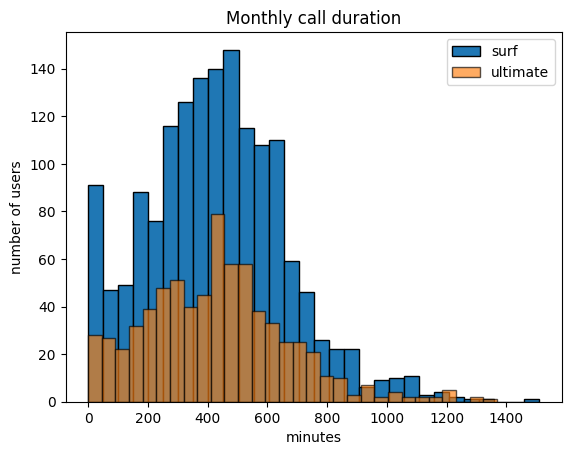

In [52]:
plt.hist(new_df.loc[new_df['plan'] == 'surf', ['duration']], edgecolor = 'black', bins=30, label= 'surf')
plt.hist(new_df.loc[new_df['plan'] == 'ultimate', ['duration']], edgecolor = 'black', bins=30, alpha = 0.65, label= 'ultimate')
plt.title('Monthly call duration')
plt.legend(loc='upper right')
plt.xlabel('minutes')
plt.ylabel('number of users')
plt.show()

### 3.2 SMS analysis <a id='sms_analysis'></a>

In [53]:
print("The average sent sms of 'surf' customers is:", np.mean(new_df.loc[new_df['plan'] == 'surf', ['sms']], axis=0).mean().round())
print("The average sent sms of 'ultimate' customers is:", np.mean(new_df.loc[new_df['plan'] == 'ultimate', ['sms']], axis=0).mean().round())

The average sent sms of 'surf' customers is: 31.0
The average sent sms of 'ultimate' customers is: 38.0


Lets now get the standard deviation for sent messages of both customers

In [54]:
# Calculating the σ for sent messages of 'surf' users
np.std(new_df.loc[new_df['plan'] == 'surf', ['sms']], axis=0)

sms    33.556046
dtype: float64

In [55]:
# Calculating the σ for sent messages of 'ultimate' users
np.std(new_df.loc[new_df['plan'] == 'ultimate', ['sms']], axis=0)

sms    34.743027
dtype: float64

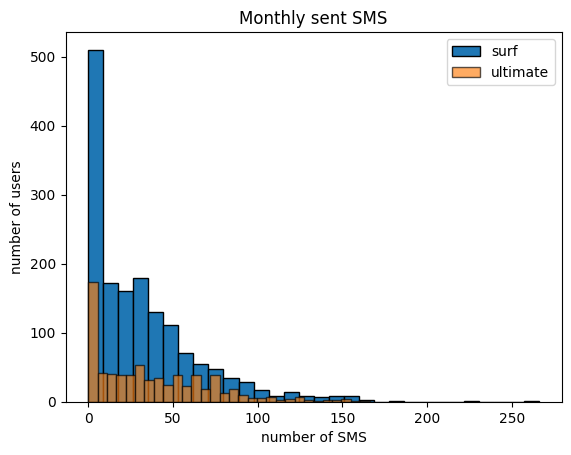

In [56]:
plt.hist(new_df.loc[new_df['plan'] == 'surf', ['sms']], edgecolor = 'black', bins=30, label= 'surf')
plt.hist(new_df.loc[new_df['plan'] == 'ultimate', ['sms']], edgecolor = 'black', bins=30, alpha = 0.65, label= 'ultimate')
plt.title('Monthly sent SMS')
plt.legend(loc='upper right')
plt.xlabel('number of SMS')
plt.ylabel('number of users')
plt.show()

### 3.3 Internet analysis <a id='Internet_analysis'></a>

In [57]:
print("The average volume of data of 'surf' customers is:", np.mean(new_df.loc[new_df['plan'] == 'surf', ['gb_used']], axis=0).mean().round())
print("The average volume of data of 'ultimate' customers is:", np.mean(new_df.loc[new_df['plan'] == 'ultimate', ['gb_used']], axis=0).mean().round())

The average volume of data of 'surf' customers is: 17.0
The average volume of data of 'ultimate' customers is: 17.0


Lets now get the standard deviation for data usage of both customers

In [58]:
# Calculating the σ for data usage of 'surf' users
np.std(new_df.loc[new_df['plan'] == 'surf', ['gb_used']], axis=0)

gb_used    7.845027
dtype: float64

In [59]:
# Calculating the σ for data usage of 'ultimate' users
np.std(new_df.loc[new_df['plan'] == 'ultimate', ['gb_used']], axis=0)

gb_used    7.664779
dtype: float64

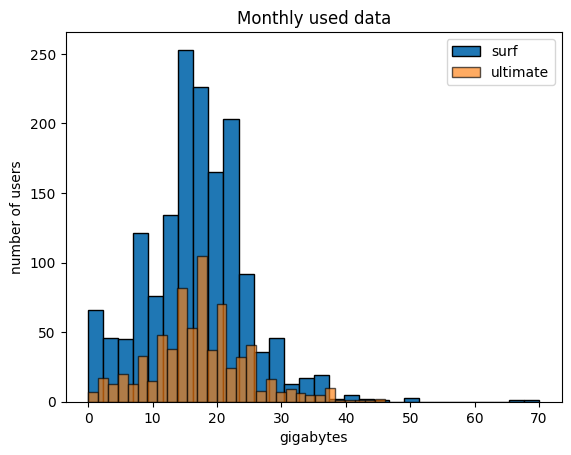

In [60]:
plt.hist(new_df.loc[new_df['plan'] == 'surf', ['gb_used']], edgecolor = 'black', bins=30, label= 'surf')
plt.hist(new_df.loc[new_df['plan'] == 'ultimate', ['gb_used']], edgecolor = 'black', bins=30, alpha = 0.65, label= 'ultimate')
plt.title('Monthly used data')
plt.legend(loc='upper right')
plt.xlabel('gigabytes')
plt.ylabel('number of users')
plt.show()

### 3.4 Month-by-month income analysis <a id='income_analysis'></a>

It is also interesting to see how income varies throughout the year for both offers

In [61]:
month_plot = new_df.pivot_table(index='month', columns='plan', values='total_pay', aggfunc='mean')


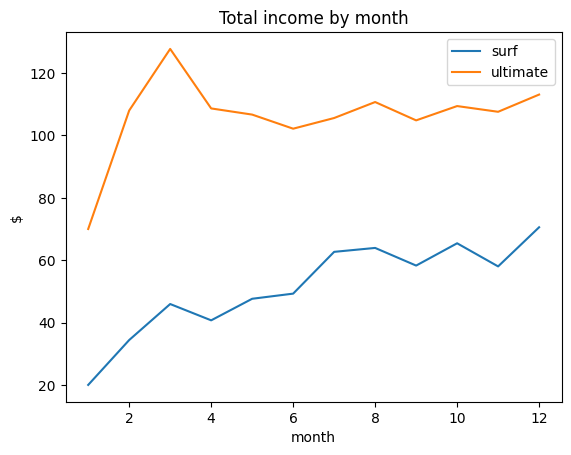

In [62]:
plt.plot(month_plot, label= ['surf', 'ultimate'])
plt.title('Total income by month')
plt.legend(loc='upper right')
plt.xlabel('month')
plt.ylabel('$')
plt.show()

So, it is clearly visible that the 'ultimate' offer represent the highest revenue source all year long for Megaline. 

## Stage 4. Hypotesis testing <a id='hypotesis_testing'></a>

### 4.1 Test: inequality of the averages 'Surf' and 'Ultimate' <a id='first_test'></a>

Hypothesis are claims, and we can use statistics to prove or disprove them. So we can check whether or not the claims are valid. To test our hypothesis we will follow these points:
- state the null hypothesis (H0)
- state the alternative hypothesis (Ha)
- determine a significance level
- calculate the p-value
- draw conclusion

The first claim is: The average income of the users of the Ultimate and Surf rates differ.

Lets set the Null Hypothesis (H0) and the Alternative Hypothesis (Ha):
- H0: no difference exist between the average income of Ultimate and Surf users
- Ha: a difference does exist between the average income of Ultimate and Surf users

We can assume a 95% of confidence level (meaning a 5% of significance level, α=5%) and so the question is: at α=5%, is there enough evidence to support the idea that the average income of 'surf' users differs from that of 'ultimate' users?

In [63]:
# getting the two samples to compare
income_surf = new_df.loc[new_df['plan'] == 'surf', ['total_pay']].values.tolist()
income_ultimate = new_df.loc[new_df['plan'] == 'ultimate', ['total_pay']].values.tolist()

alpha = 0.05  # the level of critical statistical significance

results = st.ttest_ind(income_surf, income_ultimate, equal_var = False)

print('p-value: ', results.pvalue)


if results.pvalue < alpha:  # if the p-value is less than alpha, we reject the hypothesis
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value:  [9.79926825e-99]
We reject the null hypothesis


Rejecting the null hypotesis in this case means that, with a significance level of 5%, the statement "no difference exist between the average income of Ultimate and Surf users" is false.  This does not necessarily mean that the alternative hypothesis is true.

Let's trace an histogram that resume the monthly per-capita income of both offers

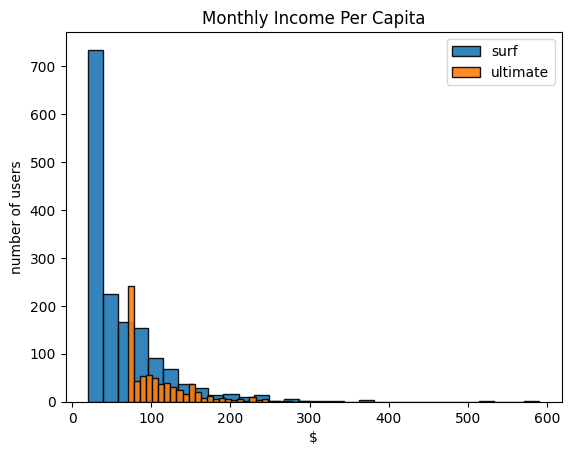

In [64]:
plt.hist(new_df.loc[new_df['plan'] == 'surf', ['total_pay']], edgecolor = 'black', bins=30, alpha = 0.9, label= 'surf')
plt.hist(new_df.loc[new_df['plan'] == 'ultimate', ['total_pay']], edgecolor = 'black', bins=30, alpha = 0.9, label= 'ultimate')
plt.title('Monthly Income Per Capita')
plt.legend(loc='upper right')
plt.xlabel('$')
plt.ylabel('number of users')
plt.show()

### 4.2 Test: inequality of the averages 'New York' and 'not New York' <a id='second_test'></a>

The second claim is: The average income of users in the New York-New is different from users in other regions.

Lets set the Null Hypothesis (H0) and the Alternative Hypothesis (Ha):
- H0: no difference exists between the average income of New York users and all the other ones
- Ha: difference does exist between the average income of New York users and all the other ones

We can assume a 95% of confidence level (meaning a 5% of significance level, α=5%) and so the question is: at α=5%, is there enough evidence to support the idea that the average income of New York users differs from that of not New Yorker users?

In [65]:
# getting the two samples to compare
income_in_new_york = new_df.loc[new_df['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA', ['total_pay']].values.tolist()
income_out_new_york = new_df.loc[new_df['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA', ['total_pay']].values.tolist()

alpha = 0.05  # the level of critical statistical significance

results_2 = st.ttest_ind(income_in_new_york, income_out_new_york, equal_var = False)

print('p-value: ', results_2.pvalue)


if results_2.pvalue < alpha:  # if the p-value is less than alpha, we reject the hypothesis
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value:  [0.00059754]
We reject the null hypothesis


Rejecting the null hypotesis in this case means that, with a significance level of 5%, the statement "no difference exists between the average income of Ultimate and Surf users" is false.  This does not necessarily mean that the alternative hypothesis is true.

In other words, the p value tells us that even though the average amounts for the two samples are different, there is a 0.036% chance of randomly not getting a difference of that size or greater. This probability is clearly not big enough to conclude that there is a significant difference between the samples.

Let's trace an histogram that resume the monthly per-capita income from New York users and not New York users

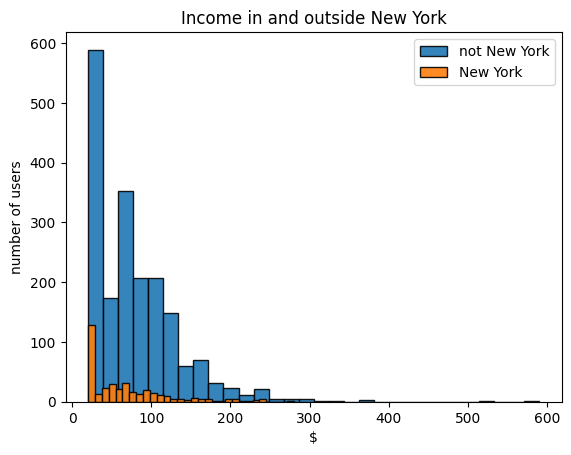

In [66]:
plt.hist(new_df.loc[new_df['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA', ['total_pay']], edgecolor = 'black', bins=30, alpha = 0.9, label= 'not New York')
plt.hist(new_df.loc[new_df['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA', ['total_pay']], edgecolor = 'black', bins=30, alpha = 0.9, label= 'New York')
plt.title('Income in and outside New York')
plt.legend(loc='upper right')
plt.xlabel('$')
plt.ylabel('number of users')
plt.show()

### 4.3 Last details <a id='details'></a>

In [67]:
print("The customers with 'surf' promo are", len(new_df.loc[new_df['plan'] == 'surf']))
print("The customers with 'ultimate' promo are", len(new_df.loc[new_df['plan'] == 'ultimate']))

The customers with 'surf' promo are 1573
The customers with 'ultimate' promo are 720


In [68]:
print("The total income from 'surf' clients is", new_df.loc[new_df['plan'] == 'surf', 'total_pay'].sum().round(), '$')
print("The total income from 'ultimate' clients is", new_df.loc[new_df['plan'] == 'ultimate', 'total_pay'].sum(), '$')

The total income from 'surf' clients is 95491.0 $
The total income from 'ultimate' clients is 78197.0 $


In [69]:
print("The average income from 'surf' clients is", (new_df.loc[new_df['plan'] == 'surf', 'total_pay'].sum()/len(new_df.loc[new_df['plan'] == 'surf'])).astype(int), '$')
print("The average income from 'ultimate' clients is", (new_df.loc[new_df['plan'] == 'ultimate', 'total_pay'].sum()/len(new_df.loc[new_df['plan'] == 'ultimate'])).astype(int), '$')

The average income from 'surf' clients is 60 $
The average income from 'ultimate' clients is 108 $


## Conclusion <a id='conclusion'></a>

We started our project with the aim of better targeting the budget of the telecom operator Megaline. The ask was to verify which one of the prepaid subscription plans is more remunerative.

Megaline provided us with 5 data tables concerning info about users calls, messages, data, personal info and of course subscription choosen.

First step was to load, verify and preprocess our data and so we did. We adjust some type, added some columns. After we made a ad-hoc dataframe "new_df" on which we based our analysis to eventually arrive at the total cost per month that the users had to pay (including basic and extra costs)

Finally we run an equality hypothesis test. This tests if two or more population means are different. Population in our case were:
- 'surf' and 'ultimate' users
- 'New York' and 'not New York' users

In both cases we rejected the null hypothesis

Now, based on their identified marketing goals, Megaline marketing department will know for sure how to aim its budget